## Step1 – Preprocessing and EDA

In [799]:
!pip install pandas networkx matplotlib pyvis py2cytoscape sns
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from py2cytoscape.data.cyrest_client import CyRestClient
import re
import community as community_louvain

In [771]:
# Load data
artists = pd.read_csv("artists.csv")
relationships = pd.read_csv("relationships.csv")
institutions = pd.read_csv("institutions.csv")
schools = pd.read_csv("schools.csv")
artists.head()

artistUrl                        id  \
0  /en/ancient-egyptian-painting  5d230b31edc2c9fb74ae130a   
1      /en/ancient-greek-pottery  5ced09b1edc2c993247c1ea0   
2     /en/ancient-greek-painting  5ce3c54dedc2c921c4035b7d   
3                    /en/apelles  5ba232ccedc2c918cc654ea8   
4             /en/fayum-portrait  5beea1ededc2c915a01acdda   

                                               image     nation  \
0  https://uploads2.wikiart.org/00244/images/anci...  Egyptians   
1  https://uploads7.wikiart.org/00238/images/anci...     Greeks   
2  https://uploads8.wikiart.org/00237/images/anci...     Greeks   
3  https://uploads2.wikiart.org/00202/images/apel...      Greek   
4  https://uploads7.wikiart.org/00210/images//01....  Egyptians   

                                  title totalWorksTitle                  year  
0                         Ancient Egypt    169 artworks  c.3150 BC - c.640 AD  
1                 Ancient Greek Pottery     87 artworks         c.900 - 31 BC  
2  Ancient Greek Painting and Sculpture     76 artworks       c.700 - c.31 BC  
3                               Apelles      8 artworks         born c.370 BC  
4                        Fayum portrait     76 artworks          c.50 - c.250

## Checking for missing values.

In [772]:
nan_counts_artists = artists.isna().sum()
nan_counts_relationships = relationships.isna().sum()
nan_counts_institutions = institutions.isna().sum()
nan_counts_schools = schools.isna().sum()
nan_counts_artists, nan_counts_relationships, nan_counts_institutions, nan_counts_schools

(artistUrl           0
 id                  0
 image               0
 nation             32
 title               0
 totalWorksTitle     0
 year                1
 dtype: int64,
 artistUrl           0
 friends          2580
 influenced_by    2512
 influenced_on    2637
 institution      2362
 movements          40
 school           1966
 type                1
 dtype: int64,
 city       2
 country    2
 title      0
 url        0
 dtype: int64,
 title    0
 url      0
 dtype: int64)

## Data distribution (movements, nationalities, artworks, etc).

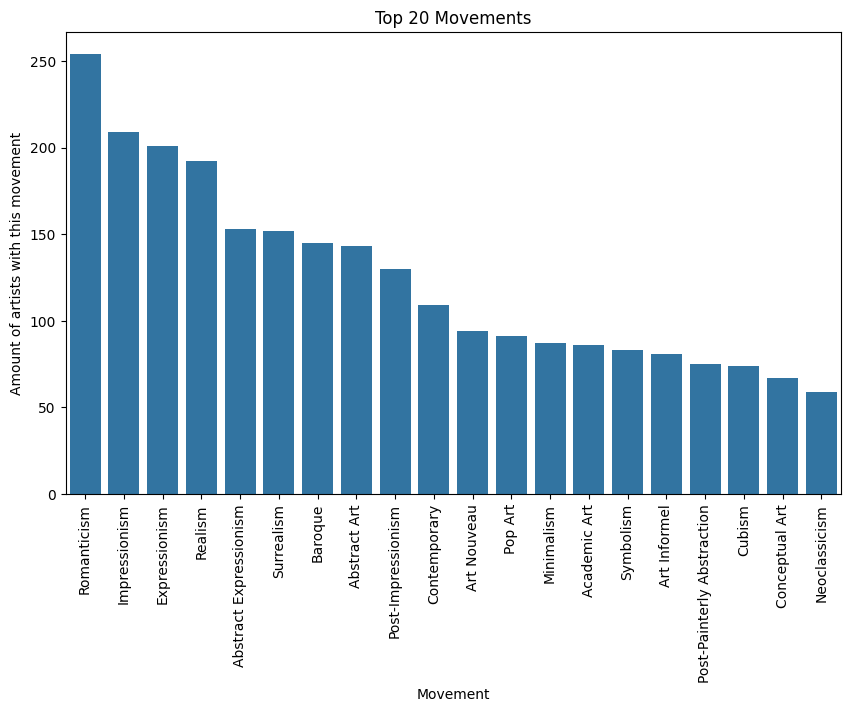

In [773]:
# Movements
unique_movements = relationships["movements"].dropna().unique()
unique_movements.sort()
#print(unique_movements)

# need to split the data on ,
count_movements = relationships["movements"].dropna().str.split(",")
#xplode and remove white spaces
count_movements = count_movements.explode().str.strip()
count_movements = count_movements.value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=count_movements.index, y=count_movements.values)
plt.title("Top 20 Movements")
plt.xlabel("Movement")
plt.ylabel("Amount of artists with this movement")
plt.xticks(rotation=90)
plt.show()

In [774]:
# nationalities
#check nationalitys
unique_nations = artists["nation"].dropna().unique()
unique_nations.sort()
print(unique_nations)


['Albanian' 'American' 'Americans' 'Angolan' 'Argentinean' 'Armenian'
 'Australian' 'Austrian' 'Austrians' 'Azerbaijani' 'Bahraini'
 'Bangladeshis' 'Barbadian' 'Belarusian' 'Belgian' 'Bengali' 'Bosnian'
 'Brazilian' 'British' 'Bulgarian' 'Bulgarians' 'Cameroonian' 'Canadian'
 'Chilean' 'Chinese' 'Colombian' 'Croatian' 'Croatians' 'Cuban' 'Czech'
 'Danish' 'Dominican' 'Dutch' 'Ecuadorian' 'Egyptian' 'Egyptians'
 'Emirati' 'Estonian' 'Ethiopian' 'Ethiopians' 'Filipino' 'Finnish'
 'Flemish' 'French' 'Georgian' 'German' 'Germans' 'Greek' 'Greeks'
 'Hungarian' 'Icelandic' 'Indian' 'Indigenous North Americans'
 'Indonesian' 'Iranian' 'Iranians' 'Iraqi' 'Irish' 'Israeli' 'Italian'
 'Italians' 'Jamaican' 'Japanese' 'Jewish' 'Latvian' 'Lebanese' 'Libyan'
 'Lithuanian' 'Luxembourgers' 'Macedonian' 'Mexican' 'Moldovans' 'Mongol'
 'Moroccan' 'New Zealander' 'Nigerian' 'Norwegian' 'Norwegians'
 'Palestinians' 'Peruvian' 'Polish' 'Portuguese' 'Puerto Rican' 'Romanian'
 'Romanians' 'Russian' 'Russian

In [775]:
# Fix the data to be standard so to singular
replacement_map = {
    "Austrians": "Austrian",
    "Bangladeshis":"Bangladeshi",
    "Bulgarians": "Bulgarian",
    "Croatians":"Croatian",
    "Egyptians": "Egyptian",
    "Ethiopians": "Ethiopian",
    "Greeks": "Greek",
    "Indigenous North Americans": "Indigenous North American",
    "Iranians": "Iranian",
    "Italians": "Italian",
    "Luxembourgers":"Luxembourger",
    "Norwegians": "Norwegian",
    "Palestinians":"'Palestinian",
    "Romanians": "Romanian",
    "Russians":"Russian",
    "Tunisians":"Tunisian",
    "Ukrainians":"Ukrainian"
}

# replace the nations to nation
artists["nation"] = artists["nation"].replace(replacement_map)
unique_nations = artists["nation"].dropna().unique()
unique_nations.sort()
print(unique_nations)

["'Palestinian" 'Albanian' 'American' 'Americans' 'Angolan' 'Argentinean'
 'Armenian' 'Australian' 'Austrian' 'Azerbaijani' 'Bahraini' 'Bangladeshi'
 'Barbadian' 'Belarusian' 'Belgian' 'Bengali' 'Bosnian' 'Brazilian'
 'British' 'Bulgarian' 'Cameroonian' 'Canadian' 'Chilean' 'Chinese'
 'Colombian' 'Croatian' 'Cuban' 'Czech' 'Danish' 'Dominican' 'Dutch'
 'Ecuadorian' 'Egyptian' 'Emirati' 'Estonian' 'Ethiopian' 'Filipino'
 'Finnish' 'Flemish' 'French' 'Georgian' 'German' 'Germans' 'Greek'
 'Hungarian' 'Icelandic' 'Indian' 'Indigenous North American' 'Indonesian'
 'Iranian' 'Iraqi' 'Irish' 'Israeli' 'Italian' 'Jamaican' 'Japanese'
 'Jewish' 'Latvian' 'Lebanese' 'Libyan' 'Lithuanian' 'Luxembourger'
 'Macedonian' 'Mexican' 'Moldovans' 'Mongol' 'Moroccan' 'New Zealander'
 'Nigerian' 'Norwegian' 'Peruvian' 'Polish' 'Portuguese' 'Puerto Rican'
 'Romanian' 'Russian' 'Scottish' 'Serbian' 'Slovak' 'Slovenian'
 'South African' 'South Korean' 'Spanish' 'Sudanese' 'Swedish' 'Swiss'
 'Syrian' 'Thai' '

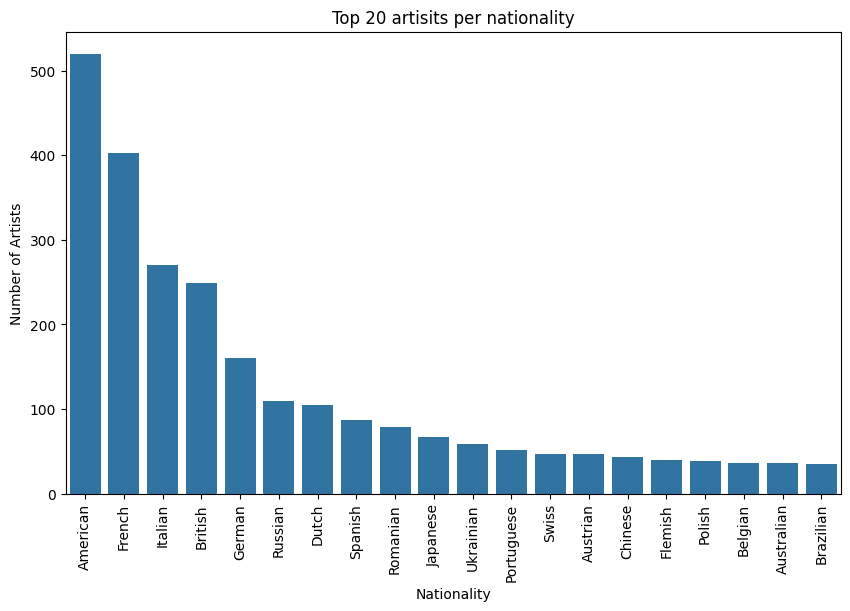

In [776]:

nation_counts = artists["nation"].value_counts()
top_nation_counts = nation_counts.head(20)
# Plotting the nationalities using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x=top_nation_counts.index, y=top_nation_counts.values)
plt.title("Top 20 artisits per nationality")
plt.xlabel("Nationality")
plt.ylabel("Number of Artists")
plt.xticks(rotation=90)
plt.show()

In [777]:
#artworks
artworks_count = artists["totalWorksTitle"].str.extract("(\d+)").astype(int)

mean_artworks = artworks_count.iloc[:, 0].mean()
median_artworks = artworks_count.iloc[:, 0].median()
sum_artworks = artworks_count.iloc[:, 0].sum()
artist_count = artworks_count.iloc[:, 0].count()

print("Mean number of artworks:", mean_artworks)
print("Median number of artworks:", median_artworks)
print("Total number of artworks:", sum_artworks)
print("Total number of artists:", artist_count)

Mean number of artworks: 57.14052069425901
Median number of artworks: 27.0
Total number of artworks: 171193
Total number of artists: 2996


Counts of each type:
type
Artists        2988
Collections       7
Name: count, dtype: int64


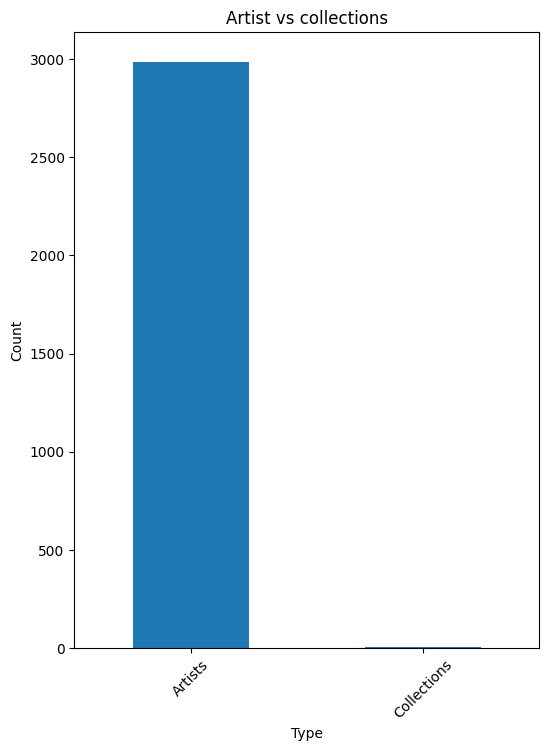

In [778]:
# etc
# artists vs collections
type_counts = relationships["type"].value_counts()

plt.figure(figsize=(6, 8))
type_counts.plot(kind="bar")


print("Counts of each type:")
print(type_counts)

plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Artist vs collections")
plt.xticks(rotation=45)
plt.show()

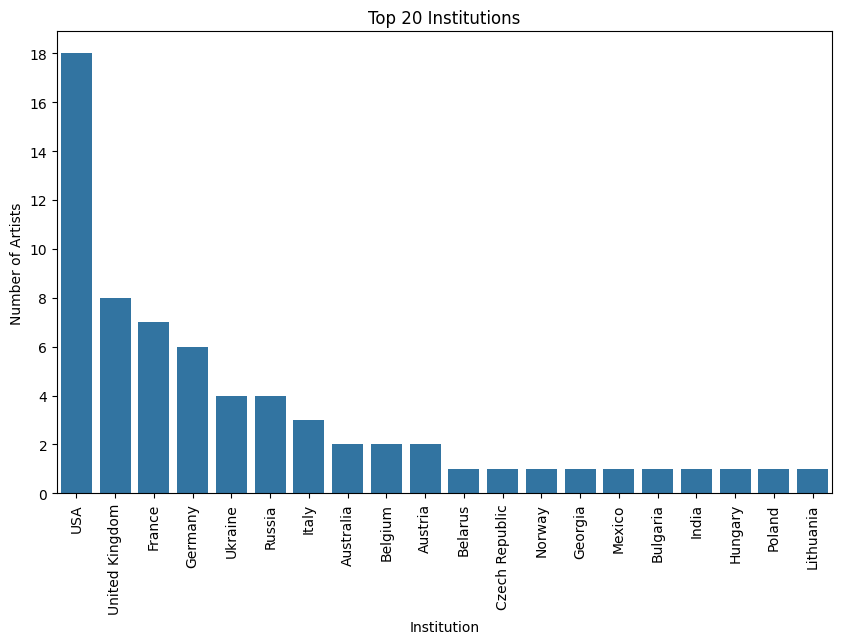

In [779]:
# etc
# Institutions per country
institutions["country"] = institutions["country"].replace({
    "UK": "United Kingdom",
    "New York City": "USA",
    "Victoria": "Australia",
    "Gujarat": "India"

})
# make the states USA
institutions["country"] = institutions["country"].apply(lambda x: "USA" if isinstance(x, str) and len(x) == 2 else x)

count_institutions = institutions["country"].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=count_institutions.index, y=count_institutions.values)
plt.title("Top 20 Institutions")
plt.xlabel("Institution")
plt.ylabel("Number of Artists")
plt.xticks(rotation=90)
plt.yticks(ticks=range(0, int(count_institutions.values.max()) + 2, 2))
plt.show()

## Create a network based on the given data: consider the nodes, the edges, the attributes, etc.

In [780]:
# create graph
G = nx.DiGraph()


In [781]:
# add artist nodes
# features artistUrl, nation, title, totalWorksTitle
artists["totalWorksTitle"] = artists["totalWorksTitle"].str.extract("(\d+)").fillna(0).astype(int)

artist_nodes = artists["artistUrl"].tolist()

artists_titles = artists.set_index("artistUrl")["title"].to_dict()
artists_nations = artists.set_index("artistUrl")["nation"].to_dict()
artists_total_art_works = artists.set_index("artistUrl")["totalWorksTitle"].to_dict()
node_type = {url: "artist" for url in artist_nodes}

G.add_nodes_from(artist_nodes)
nx.set_node_attributes(G, artists_titles, "title")
nx.set_node_attributes(G, artists_nations, "nation")
nx.set_node_attributes(G, artists_total_art_works, "totalWorksTitle")
nx.set_node_attributes(G, node_type, "type")

for node, data in G.nodes(data=True):
    print(data)

{'title': 'Ancient Egypt', 'nation': 'Egyptian', 'totalWorksTitle': 169, 'type': 'artist'}
{'title': 'Ancient Greek Pottery', 'nation': 'Greek', 'totalWorksTitle': 87, 'type': 'artist'}
{'title': 'Ancient Greek Painting and Sculpture', 'nation': 'Greek', 'totalWorksTitle': 76, 'type': 'artist'}
{'title': 'Apelles', 'nation': 'Greek', 'totalWorksTitle': 8, 'type': 'artist'}
{'title': 'Fayum portrait', 'nation': 'Egyptian', 'totalWorksTitle': 76, 'type': 'artist'}
{'title': 'Orthodox Icons', 'nation': 'Greek', 'totalWorksTitle': 437, 'type': 'artist'}
{'title': 'Wu Daozi', 'nation': 'Chinese', 'totalWorksTitle': 8, 'type': 'artist'}
{'title': 'Wang Wei', 'nation': 'Chinese', 'totalWorksTitle': 4, 'type': 'artist'}
{'title': 'Han Gan', 'nation': 'Chinese', 'totalWorksTitle': 4, 'type': 'artist'}
{'title': 'Chen Hong', 'nation': 'Chinese', 'totalWorksTitle': 3, 'type': 'artist'}
{'title': 'Guanxiu', 'nation': 'Chinese', 'totalWorksTitle': 16, 'type': 'artist'}
{'title': 'Li Cheng', 'nation

In [782]:
# add institution nodes
# features title, url, country and city
institution_nodes = institutions["url"].tolist()

institutions_titles = institutions.set_index("url")["title"].to_dict()
institutions_countries = institutions.set_index("url")["country"].fillna("N/A").to_dict()
institutions_cities = institutions.set_index("url")["city"].fillna("N/A").to_dict()
institution_type = {url: "institution" for url in institution_nodes}

G.add_nodes_from(institution_nodes)
nx.set_node_attributes(G, institutions_titles, "title")
nx.set_node_attributes(G, institutions_countries, "country")
nx.set_node_attributes(G, institutions_cities, "city")
nx.set_node_attributes(G, institution_type, "type")

In [783]:
"""
# add movements nodes
# features none
count_movements = relationships["movements"].dropna().str.split(",").explode().str.strip()
movement_nodes = set(count_movements)

G.add_nodes_from(movement_nodes)
movement_type = {movement: "movement" for movement in movement_nodes}
nx.set_node_attributes(G, movement_type, "type")
for node, data in G.nodes(data=True):
 if data.get("type") == "movement":
        print(node, data)
"""

'\n# add movements nodes\n# features none\ncount_movements = relationships["movements"].dropna().str.split(",").explode().str.strip()\nmovement_nodes = set(count_movements)\n\nG.add_nodes_from(movement_nodes)\nmovement_type = {movement: "movement" for movement in movement_nodes}\nnx.set_node_attributes(G, movement_type, "type")\nfor node, data in G.nodes(data=True):\n if data.get("type") == "movement":\n        print(node, data)\n'

In [784]:
# add schools
# features title
school_nodes = schools["url"].tolist()
schools_titles = schools.set_index("url")["title"].to_dict()
school_type = {url: "school" for url in school_nodes}

G.add_nodes_from(school_nodes)
nx.set_node_attributes(G, schools_titles, "title")
nx.set_node_attributes(G, school_type, "type")
for node, data in G.nodes(data=True):
    if data.get("type") == "school":
        print(node, data)

/en/artists-by-painting-school/flemish-school {'title': 'Flemish School', 'type': 'school'}
/en/artists-by-painting-school/sienese-school {'title': 'Sienese School', 'type': 'school'}
/en/artists-by-painting-school/umbrian-school {'title': 'Umbrian school', 'type': 'school'}
/en/artists-by-painting-school/florentine-school {'title': 'Florentine School', 'type': 'school'}
/en/artists-by-painting-school/parma-school {'title': 'Parma school', 'type': 'school'}
/en/artists-by-painting-school/german-school {'title': 'German School', 'type': 'school'}
/en/artists-by-painting-school/ferrara-school {'title': 'Ferrara School', 'type': 'school'}
/en/artists-by-painting-school/dutch-school {'title': 'Dutch School', 'type': 'school'}
/en/artists-by-painting-school/valencian-school {'title': 'Valencian school', 'type': 'school'}
/en/artists-by-painting-school/lombard-school {'title': 'Lombard School', 'type': 'school'}
/en/artists-by-painting-school/tuscan-school {'title': 'Tuscan school', 'type': 

In [785]:
# add edges

# in relationships artist node can have friends which are other artist
# need to use split on , as the data of friends can be /en/albrecht-durer,/en/sebastiano-del-piombo (make it an undirected edge)
#, influenced_by which can be an other artist, school, movements, same thing here need to split on , (an directed edge to artist as the artist is influenced by xxx)
# influenced_on which can be an other artist, school, movements, same thing here need to split on , (an directed edge from artist as the artist influenced on xxx)
# artist to instituion , same thing here need to split on , (unsure what kind of vertex it should be but the artist can have been a teacher,student at the institution)
# artist to movement, same thing here need to split on , (artist was part of movement so an undirected graph )
# artist to school, artist was part of an school of art so an undircted graph, need to split on ,



# Add undirected edges for friends (artist to artist)
for index, row in relationships.iterrows():
    artist_url = row["artistUrl"]
    friends = row["friends"]
    if pd.notna(friends):
        friends_list = [friend.strip() for friend in friends.split(",")]
        for friend in friends_list:
          if not G.has_edge(artist_url, friend.strip()):
            G.add_edge(artist_url, friend, relationship="friend")
            G.add_edge(friend,artist_url, relationship="friend")

# Add directed edges for influenced_by (artist influenced by others)
for index, row in relationships.iterrows():
    artist_url = row["artistUrl"]
    influenced_by = row["influenced_by"]
    if pd.notna(influenced_by):
        influenced_by_list = [item.strip() for item in influenced_by.split(",")]
        for influence in influenced_by_list:
          if influence.startswith("/en/artists-by-art-movement/"):
            if not G.has_node(influence):
              G.add_node(influence)
              movement_type = influence.split("/")[-1]  # Get the type from the URL
              nx.set_node_attributes(G, {influence: {"type": "movement", "title": movement_type}})
              print(f"Created1 node: {influence} with type 'movement' and title '{movement_type}'")
          G.add_edge(influence, artist_url, relationship="influenced_on")

# Add directed edges for influenced_on (artist influences others)
for index, row in relationships.iterrows():
    artist_url = row["artistUrl"]
    influenced_on = row["influenced_on"]
    if pd.notna(influenced_on):
        influenced_on_list = [item.strip() for item in influenced_on.split(",")]
        for influenced in influenced_on_list:
          if influenced.startswith("/en/artists-by-art-movement/"):

            if not G.has_node(influenced):
              G.add_node(influenced)
              movement_type = influenced.split("/")[-1]  # Get the type from the URL
              nx.set_node_attributes(G, {influenced: {"type": "movement", "title": movement_type}})
              print(f"Created2 node: {influenced} with type 'movement' and title '{movement_type}'")
          G.add_edge(artist_url, influenced, relationship="influenced_on")

# Add undirected edges for artist to institution (as teachers/students)
for index, row in relationships.iterrows():
    artist_url = row["artistUrl"]
    institutions = row["institution"]
    if pd.notna(institutions):
        institutions_list = [institution.strip() for institution in institutions.split(",")]
        for institution in institutions_list:
           G.add_edge(artist_url, institution.strip(), relationship="associated_with")
           G.add_edge(institution.strip(),artist_url, relationship="associated_with")

# Add undirected edges for artist to movements (artist was part of movements)
for index, row in relationships.iterrows():
    artist_url = row["artistUrl"]
    movements = row["movements"]
    if pd.notna(movements):
        movements_list = [movement.strip() for movement in movements.split(",")]
        for movement in movements_list:
            G.add_edge(artist_url, movement.strip(), relationship="associated_with")
            G.add_edge( movement.strip(),artist_url, relationship="associated_with")

# Add undirected edges for artist to schools (artist was part of schools)
for index, row in relationships.iterrows():
    artist_url = row["artistUrl"]
    schools = row["school"]
    if pd.notna(schools):
        schools_list = [school.strip() for school in schools.split(",")]
        for school in schools_list:
            G.add_edge(artist_url, school.strip(), relationship="part_of_school")



Created1 node: /en/artists-by-art-movement/byzantine-art with type 'movement' and title 'byzantine-art'
Created1 node: /en/artists-by-art-movement/gothic-art with type 'movement' and title 'gothic-art'
Created1 node: /en/artists-by-art-movement/baroque with type 'movement' and title 'baroque'
Created1 node: /en/artists-by-art-movement/romanticism with type 'movement' and title 'romanticism'
Created1 node: /en/artists-by-art-movement/neoclassicism with type 'movement' and title 'neoclassicism'
Created1 node: /en/artists-by-art-movement/symbolism with type 'movement' and title 'symbolism'
Created1 node: /en/artists-by-art-movement/rococo with type 'movement' and title 'rococo'
Created1 node: /en/artists-by-art-movement/dutch-golden-age with type 'movement' and title 'dutch-golden-age'
Created1 node: /en/artists-by-art-movement/early-renaissance with type 'movement' and title 'early-renaissance'
Created1 node: /en/artists-by-art-movement/impressionism with type 'movement' and title 'impre

In [786]:
print(G)

DiGraph with 3662 nodes and 13839 edges


## Based on differenet network analysis techniques (centrality measures, community analysis, clustering algorithms), answer the questions (Goals: 1-5) above.

In [787]:
# 1. Which were the most influential artists?
# check artist nodes which has a high number of edges influenced on and then do a out_degree_centrality
artist_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == "artist"]
influenced_on_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get("relationship") == "influenced_on"]

influence_graph = nx.DiGraph()
influence_graph.add_edges_from(influenced_on_edges)
degree_centrality = nx.out_degree_centrality(influence_graph)
artist_centrality = [(artist, degree_centrality[artist]) for artist in artist_nodes if artist in degree_centrality]
top_artists = sorted(artist_centrality, key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Artists by Degree Centrality (based on 'influenced_on' edges):")
for artist, centrality in top_artists:
    artist_title = G.nodes[artist].get("title", "Unknown Artist")
    print(f"{artist_title} ({artist}) - Centrality: {centrality:.4f}")

Top 20 Artists by Degree Centrality (based on 'influenced_on' edges):
Pablo Picasso (/en/pablo-picasso) - Centrality: 0.0315
Paul Cezanne (/en/paul-cezanne) - Centrality: 0.0290
Rembrandt (/en/rembrandt) - Centrality: 0.0264
Caravaggio (/en/caravaggio) - Centrality: 0.0264
Titian (/en/titian) - Centrality: 0.0214
Gustave Courbet (/en/gustave-courbet) - Centrality: 0.0214
Nicolas Poussin (/en/nicolas-poussin) - Centrality: 0.0202
Diego Velazquez (/en/diego-velazquez) - Centrality: 0.0202
Raphael (/en/raphael) - Centrality: 0.0189
Henri Matisse (/en/henri-matisse) - Centrality: 0.0189
Michelangelo (/en/michelangelo) - Centrality: 0.0189
Paul Gauguin (/en/paul-gauguin) - Centrality: 0.0164
El Greco (/en/el-greco) - Centrality: 0.0151
Jean-Francois Millet (/en/jean-francois-millet) - Centrality: 0.0151
Wassily Kandinsky (/en/wassily-kandinsky) - Centrality: 0.0151
Vincent van Gogh (/en/vincent-van-gogh) - Centrality: 0.0151
Peter Paul Rubens (/en/peter-paul-rubens) - Centrality: 0.0151
Ort

Nodes influenced by the artist of interest:
Node: /en/amedeo-modigliani, Data: {'title': 'Amedeo Modigliani', 'nation': 'Italian', 'totalWorksTitle': 349, 'type': 'artist'}
Node: /en/piet-mondrian, Data: {'title': 'Piet Mondrian', 'nation': 'Dutch', 'totalWorksTitle': 101, 'type': 'artist'}
Node: /en/robert-delaunay, Data: {'title': 'Robert Delaunay', 'nation': 'French', 'totalWorksTitle': 33, 'type': 'artist'}
Node: /en/marc-chagall, Data: {'title': 'Marc Chagall', 'nation': 'French', 'totalWorksTitle': 1022, 'type': 'artist'}
Node: /en/vilhelm-lundstrom, Data: {'title': 'Vilhelm Lundstrom', 'nation': nan, 'totalWorksTitle': 10, 'type': 'artist'}
Node: /en/tamara-de-lempicka, Data: {'title': 'Tamara de Lempicka', 'nation': 'Polish', 'totalWorksTitle': 93, 'type': 'artist'}
Node: /en/arshile-gorky, Data: {'title': 'Arshile Gorky', 'nation': 'American', 'totalWorksTitle': 77, 'type': 'artist'}
Node: /en/balcomb-greene, Data: {'title': 'Balcomb Greene', 'nation': 'American', 'totalWorksT

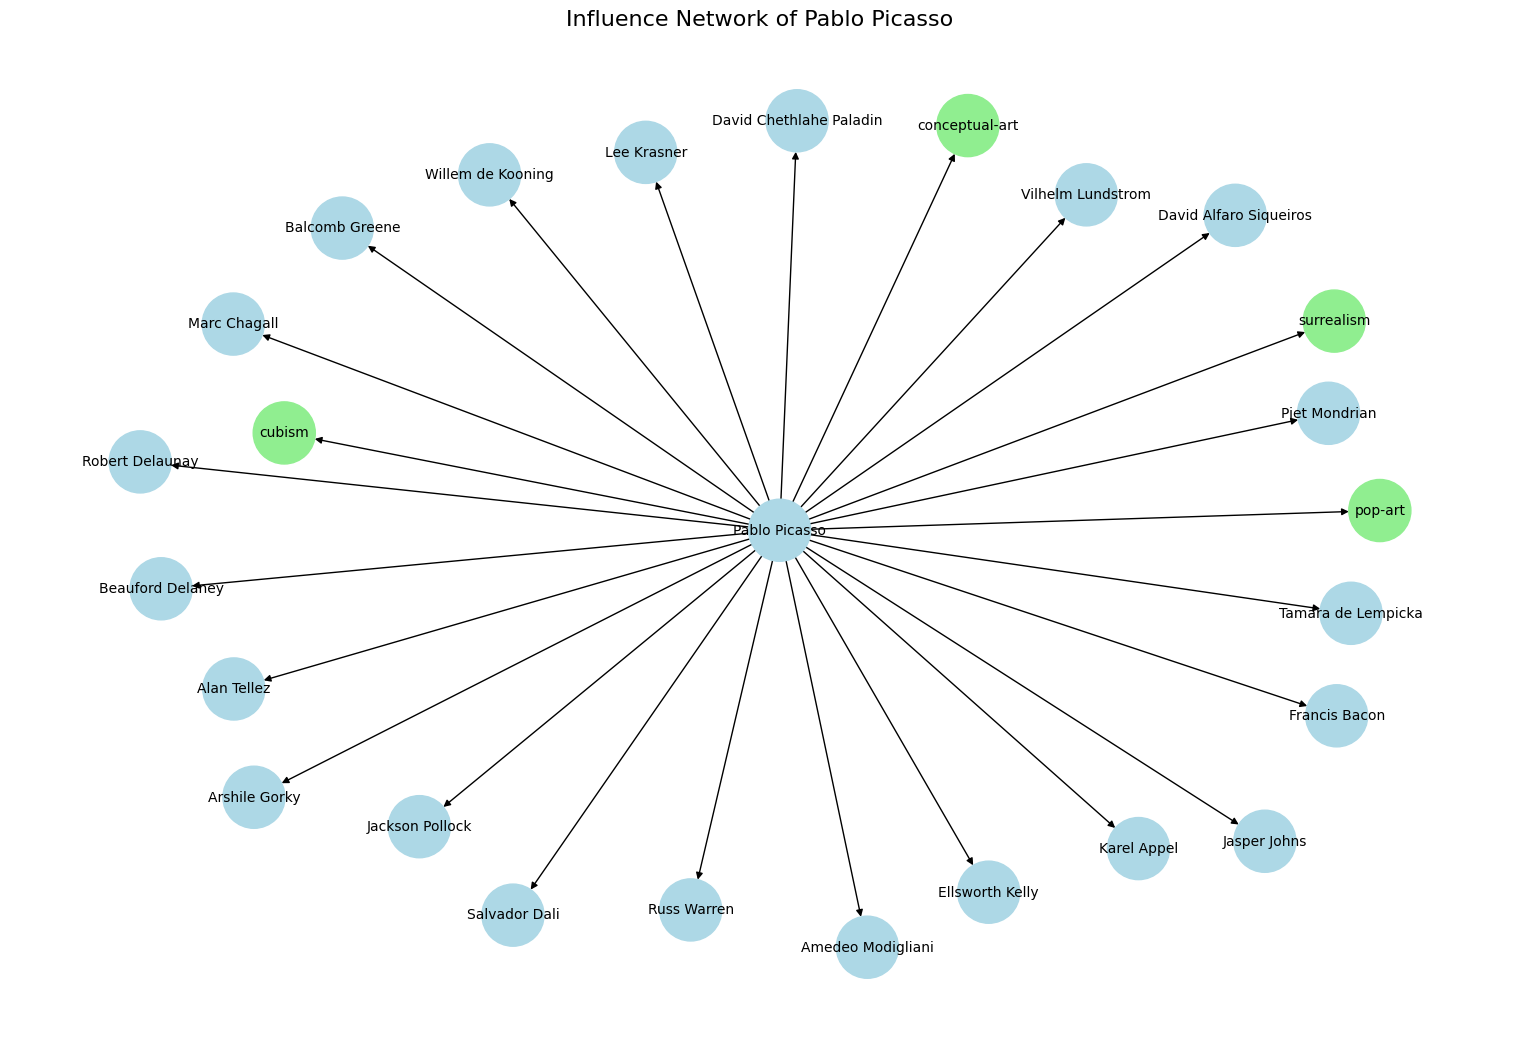

In [788]:
top_artist, top_centrality = top_artists[0]
artist_of_interest = top_artist

top_artist, top_centrality = top_artists[0]
artist_of_interest = top_artist


influenced_nodes = []


for neighbor in G.successors(artist_of_interest):
    edge_data = G[artist_of_interest][neighbor]
    if edge_data.get("relationship") == "influenced_on":
        influenced_nodes.append(neighbor)

influenced_nodes.append(artist_of_interest)


print("Nodes influenced by the artist of interest:")
for node in influenced_nodes:
    node_data = G.nodes[node]
    print(f"Node: {node}, Data: {node_data}")

# Create a subgraph and draw it
subgraph = nx.DiGraph()


subgraph.add_node(artist_of_interest, **G.nodes[artist_of_interest])


for influenced_node in influenced_nodes:
    if influenced_node != artist_of_interest:
        subgraph.add_node(influenced_node, **G.nodes[influenced_node])
        subgraph.add_edge(artist_of_interest, influenced_node, relationship="influenced_on")


plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph)


node_colors = []
node_titles = {}

for node, data in subgraph.nodes(data=True):
    if data["type"] == "artist":
        node_colors.append("lightblue")
    elif data["type"] == "movement":
        node_colors.append("lightgreen")
    else:
        node_colors.append("lightgray")

    node_titles[node] = data["title"]


nx.draw(subgraph, pos, with_labels=False, node_size=2000, node_color=node_colors, font_size=10)


nx.draw_networkx_labels(subgraph, pos, labels=node_titles, font_size=10)

plt.title(f"Influence Network of {G.nodes[artist_of_interest]['title']}", fontsize=16)
plt.show()

In [789]:
# 2. Which were the most influential movements?
movement_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == "movement"]
influenced_on_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get("relationship") == "influenced_on"]

influence_graph = nx.DiGraph()
influence_graph.add_edges_from(influenced_on_edges)
degree_centrality = nx.out_degree_centrality(influence_graph)
movement_centrality = [(movement, degree_centrality[movement]) for movement in movement_nodes if movement in degree_centrality]
top_movements = sorted(movement_centrality, key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Movements by Degree Centrality (Influence):")
for movement, centrality in top_movements:
    movement_title = G.nodes[movement].get("title", "Unknown Movement")
    print(f"{movement_title} ({movement}) - Influence Count: {centrality}")

Top 20 Movements by Degree Centrality (Influence):
cubism (/en/artists-by-art-movement/cubism) - Influence Count: 0.013853904282115869
byzantine-art (/en/artists-by-art-movement/byzantine-art) - Influence Count: 0.011335012594458438
expressionism (/en/artists-by-art-movement/expressionism) - Influence Count: 0.007556675062972292
surrealism (/en/artists-by-art-movement/surrealism) - Influence Count: 0.007556675062972292
impressionism (/en/artists-by-art-movement/impressionism) - Influence Count: 0.006297229219143576
dada (/en/artists-by-art-movement/dada) - Influence Count: 0.006297229219143576
gothic-art (/en/artists-by-art-movement/gothic-art) - Influence Count: 0.003778337531486146
dutch-golden-age (/en/artists-by-art-movement/dutch-golden-age) - Influence Count: 0.003778337531486146
post-impressionism (/en/artists-by-art-movement/post-impressionism) - Influence Count: 0.003778337531486146
native-art (/en/artists-by-art-movement/native-art) - Influence Count: 0.003778337531486146
fut

Nodes influenced by the artist of interest:
Node: /en/piet-mondrian, Data: {'title': 'Piet Mondrian', 'nation': 'Dutch', 'totalWorksTitle': 101, 'type': 'artist'}
Node: /en/aristarkh-lentulov, Data: {'title': 'Aristarkh Lentulov', 'nation': 'Russian', 'totalWorksTitle': 30, 'type': 'artist'}
Node: /en/jose-clemente-orozco, Data: {'title': 'Jose Clemente Orozco', 'nation': 'Mexican', 'totalWorksTitle': 65, 'type': 'artist'}
Node: /en/marc-chagall, Data: {'title': 'Marc Chagall', 'nation': 'French', 'totalWorksTitle': 1022, 'type': 'artist'}
Node: /en/tamara-de-lempicka, Data: {'title': 'Tamara de Lempicka', 'nation': 'Polish', 'totalWorksTitle': 93, 'type': 'artist'}
Node: /en/rita-angus, Data: {'title': 'Rita Angus', 'nation': 'New Zealander', 'totalWorksTitle': 72, 'type': 'artist'}
Node: /en/francis-bacon, Data: {'title': 'Francis Bacon', 'nation': 'British', 'totalWorksTitle': 325, 'type': 'artist'}
Node: /en/helene-de-beauvoir, Data: {'title': 'Hélène de Beauvoir', 'nation': 'Frenc

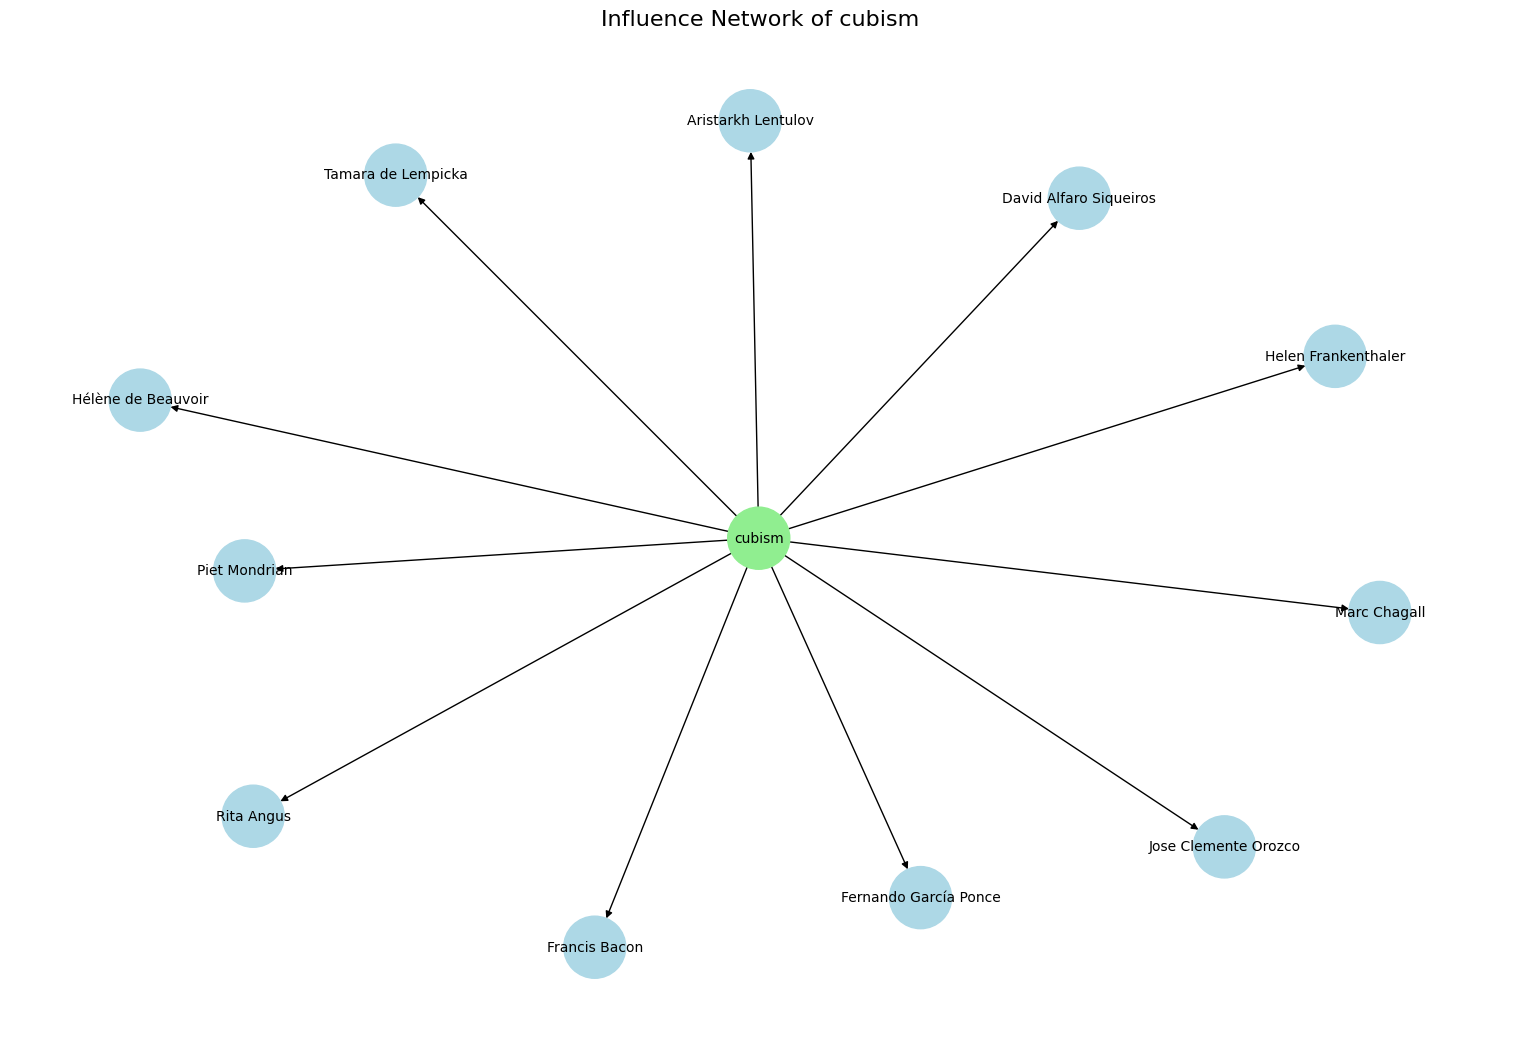

In [790]:


top_movement, top_centrality =top_movements[0]
move_of_interest = top_movement


influenced_nodes = []


for neighbor in G.successors(move_of_interest):
    edge_data = G[move_of_interest][neighbor]
    if edge_data.get("relationship") == "influenced_on":
        influenced_nodes.append(neighbor)

influenced_nodes.append(move_of_interest)


print("Nodes influenced by the artist of interest:")
for node in influenced_nodes:
    node_data = G.nodes[node]
    print(f"Node: {node}, Data: {node_data}")

# Create a subgraph and draw it
subgraph = nx.DiGraph()


subgraph.add_node(move_of_interest, **G.nodes[move_of_interest])


for influenced_node in influenced_nodes:
    if influenced_node != move_of_interest:
        subgraph.add_node(influenced_node, **G.nodes[influenced_node])
        subgraph.add_edge(move_of_interest, influenced_node, relationship="influenced_on")


plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph)


node_colors = []
node_titles = {}

for node, data in subgraph.nodes(data=True):
    if data["type"] == "artist":
        node_colors.append("lightblue")
    elif data["type"] == "movement":
        node_colors.append("lightgreen")
    else:
        node_colors.append("lightgray")

    node_titles[node] = data["title"]


nx.draw(subgraph, pos, with_labels=False, node_size=2000, node_color=node_colors, font_size=10)


nx.draw_networkx_labels(subgraph, pos, labels=node_titles, font_size=10)

plt.title(f"Influence Network of {G.nodes[move_of_interest]['title']}", fontsize=16)
plt.show()

Top 20 Institutions by Degree Centrality (Influence):
École des Beaux-Arts (/en/artists-by-art-institution/cole-des-beaux-arts) - Influence Count: 0.0241
Académie Julian (/en/artists-by-art-institution/acad-mie-julian) - Influence Count: 0.0158
Art Students League of New York (/en/artists-by-art-institution/art-students-league) - Influence Count: 0.0152
Akademie der Bildenden Künste München (Munich Academy) (/en/artists-by-art-institution/akademie-der) - Influence Count: 0.0107
Imperial Academy of Arts (/en/artists-by-art-institution/imperial-academy-of-arts-saint-petersburg-russia) - Influence Count: 0.0104
Guild of Saint Luke (/en/artists-by-art-institution/guild-of-saint-luke) - Influence Count: 0.0092
Royal Academy of Arts (RA) (/en/artists-by-art-institution/royal-academy-of) - Influence Count: 0.0086
National Academy Museum and School (National Academy of Design) (/en/artists-by-art-institution/national-academy) - Influence Count: 0.0077
National Academy of Visual Arts and Archit

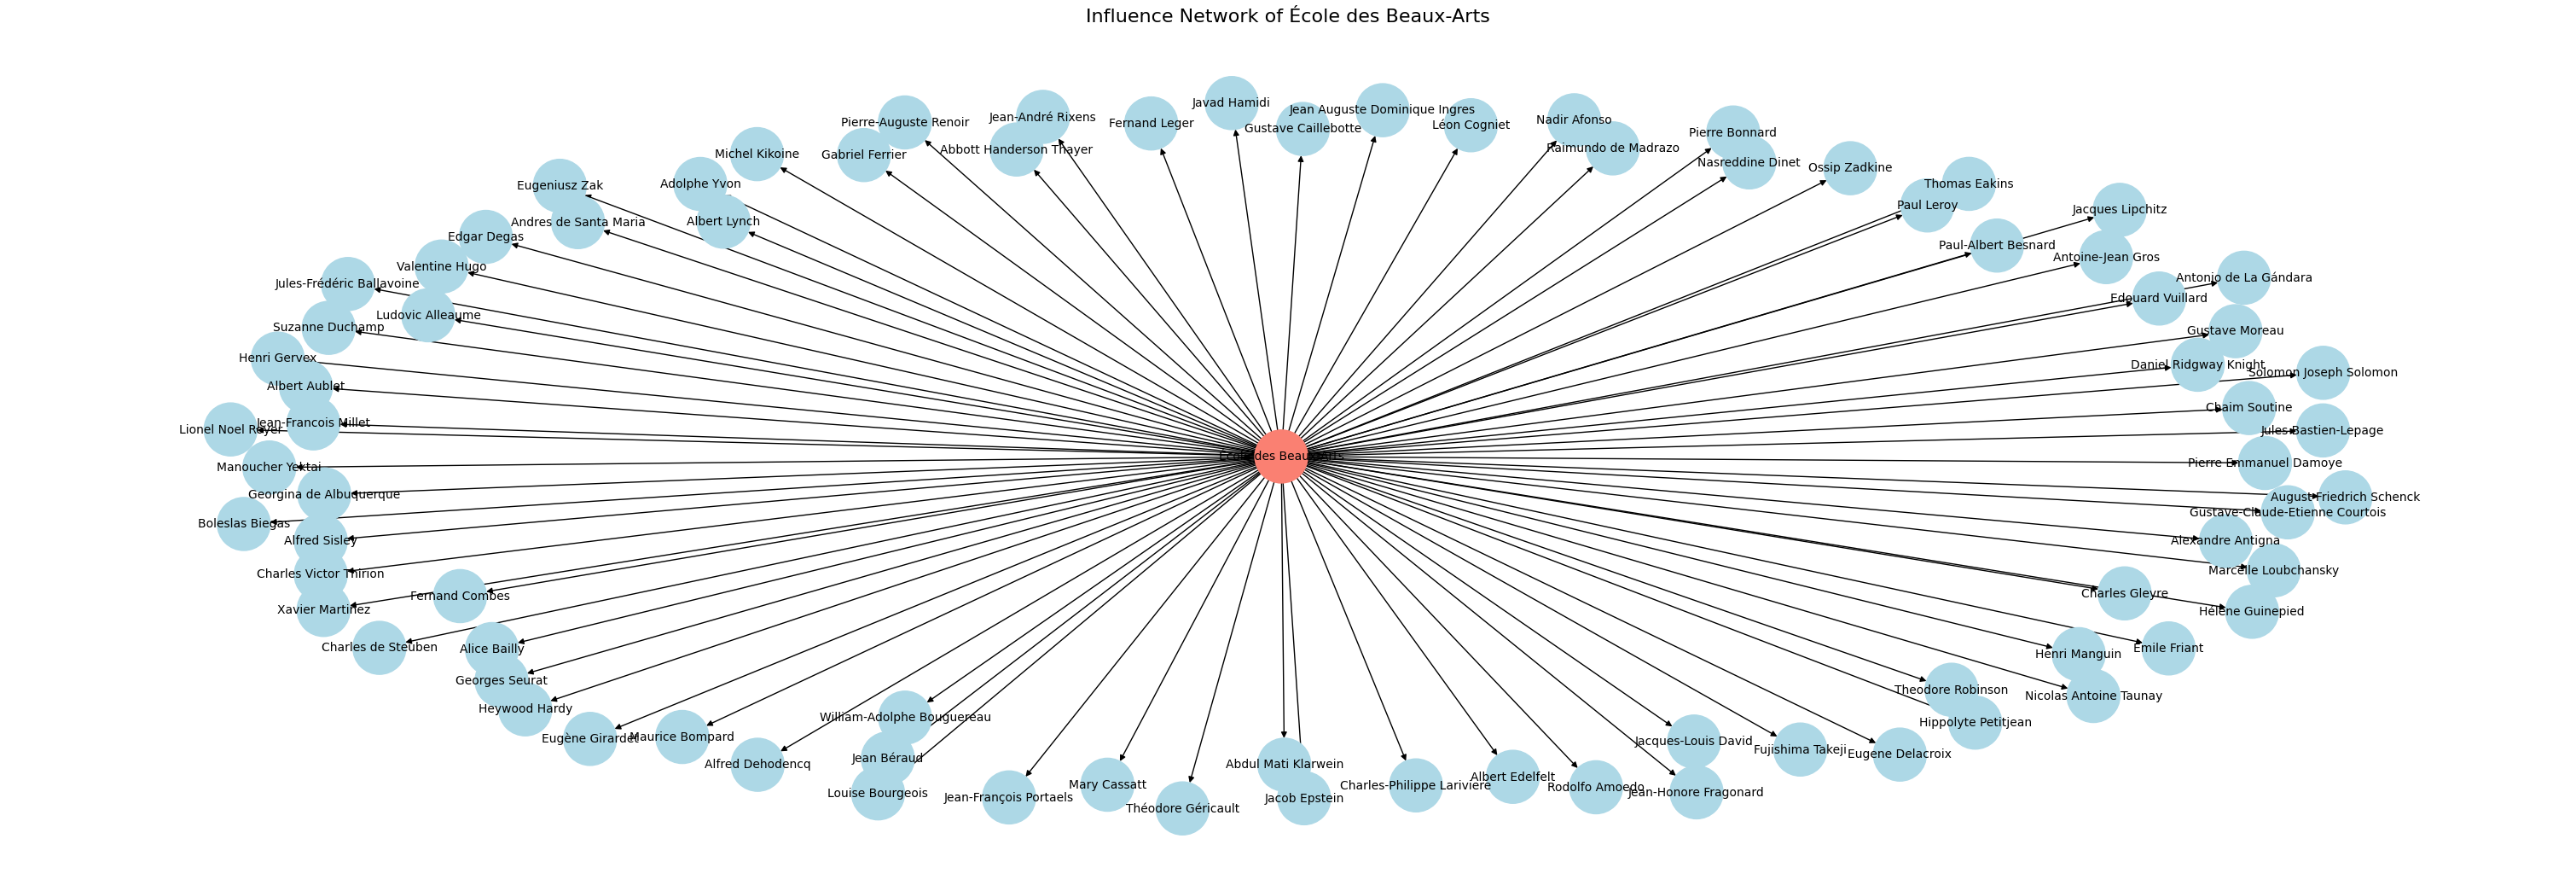

In [791]:
# 3. Which were the most influential institutions?
institution_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == "institution"]

influenced_on_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get("relationship") in ["influenced_on", "associated_with"]]

influence_graph = nx.DiGraph()
influence_graph.add_edges_from(influenced_on_edges)


degree_centrality = nx.out_degree_centrality(influence_graph)
institution_centrality = [(institution, degree_centrality[institution]) for institution in institution_nodes if institution in degree_centrality]


top_institutions = sorted(institution_centrality, key=lambda x: x[1], reverse=True)[:20]


print("Top 20 Institutions by Degree Centrality (Influence):")
for institution, centrality in top_institutions:
    institution_title = G.nodes[institution].get("title", "Unknown Institution")
    print(f"{institution_title} ({institution}) - Influence Count: {centrality:.4f}")


if top_institutions:
    top_institution, top_centrality = top_institutions[0]
    institution_of_interest = top_institution


    influenced_nodes = []


    for neighbor in G.successors(institution_of_interest):
        edge_data = G[institution_of_interest][neighbor]
        if edge_data.get("relationship") in ["influenced_on", "associated_with"]:
            influenced_nodes.append(neighbor)

    influenced_nodes.append(institution_of_interest)


    print("Nodes influenced by the institution of interest:")
    for node in influenced_nodes:
        node_data = G.nodes[node]
        print(f"Node: {node}, Data: {node_data}")

    subgraph = nx.DiGraph()
    subgraph.add_node(institution_of_interest, **G.nodes[institution_of_interest])

    for influenced_node in influenced_nodes:
        if influenced_node != institution_of_interest:
            subgraph.add_node(influenced_node, **G.nodes[influenced_node])
            relationship = G[institution_of_interest][influenced_node]["relationship"]
            subgraph.add_edge(institution_of_interest, influenced_node, relationship=relationship)


    plt.figure(figsize=(30, 10))
    pos = nx.spring_layout(subgraph)
    node_colors = []
    node_titles = {}

    for node, data in subgraph.nodes(data=True):
        if data["type"] == "artist":
            node_colors.append("lightblue")
        elif data["type"] == "movement":
            node_colors.append("lightgreen")
        elif data["type"] == "institution":
            node_colors.append("salmon")
        else:
            node_colors.append("lightgray")

        node_titles[node] = data["title"]

    nx.draw(subgraph, pos, with_labels=False, node_size=2000, node_color=node_colors, font_size=10)
    nx.draw_networkx_labels(subgraph, pos, labels=node_titles, font_size=10)
    plt.title(f"Influence Network of {G.nodes[institution_of_interest]['title']}", fontsize=16)
    plt.show()


In [792]:
# 4. Which nationalities concentrate the majority of artists?

nationality_count = defaultdict(int)

for node, data in G.nodes(data=True):
    if data.get("type") == "artist":
        nation = data.get("nation")
        if nation:
            nationality_count[nation] += 1


sorted_nationalities = sorted(nationality_count.items(), key=lambda x: x[1], reverse=True)
print("Number of Artists by Nationality:")
for nation, count in sorted_nationalities:
    print(f"{nation}: {count}")

Number of Artists by Nationality:
American: 520
French: 402
Italian: 270
British: 249
German: 160
Russian: 110
Dutch: 105
Spanish: 87
Romanian: 79
Japanese: 67
Ukrainian: 59
Portuguese: 52
Swiss: 47
Austrian: 47
Chinese: 43
Flemish: 40
Polish: 38
Belgian: 36
Australian: 36
Brazilian: 35
Canadian: 35
Jewish: 33
nan: 32
Hungarian: 30
Mexican: 29
Iranian: 24
Greek: 22
Armenian: 22
Swedish: 18
Argentinean: 15
Norwegian: 14
Turkish: 14
Czech: 14
Indian: 13
Bulgarian: 13
South African: 12
Finnish: 11
Irish: 10
Danish: 9
South Korean: 8
Cuban: 7
Colombian: 6
Venezuelan: 6
Azerbaijani: 6
Croatian: 5
Belarusian: 5
Serbian: 5
Egyptian: 4
Indonesian: 4
Slovenian: 4
Americans: 4
Lithuanian: 4
Peruvian: 4
Georgian: 3
New Zealander: 3
Latvian: 3
Icelandic: 3
Indigenous North American: 3
Filipino: 3
'Palestinian: 3
Ethiopian: 3
Moldovans: 3
Nigerian: 3
Scottish: 2
Puerto Rican: 2
Uruguayan: 2
Slovak: 2
Macedonian: 2
Vietnamese: 2
Chilean: 2
Ecuadorian: 2
Jamaican: 2
Albanian: 2
Germans: 1
Estonian: 1

Top Nationality: American with 520 artists


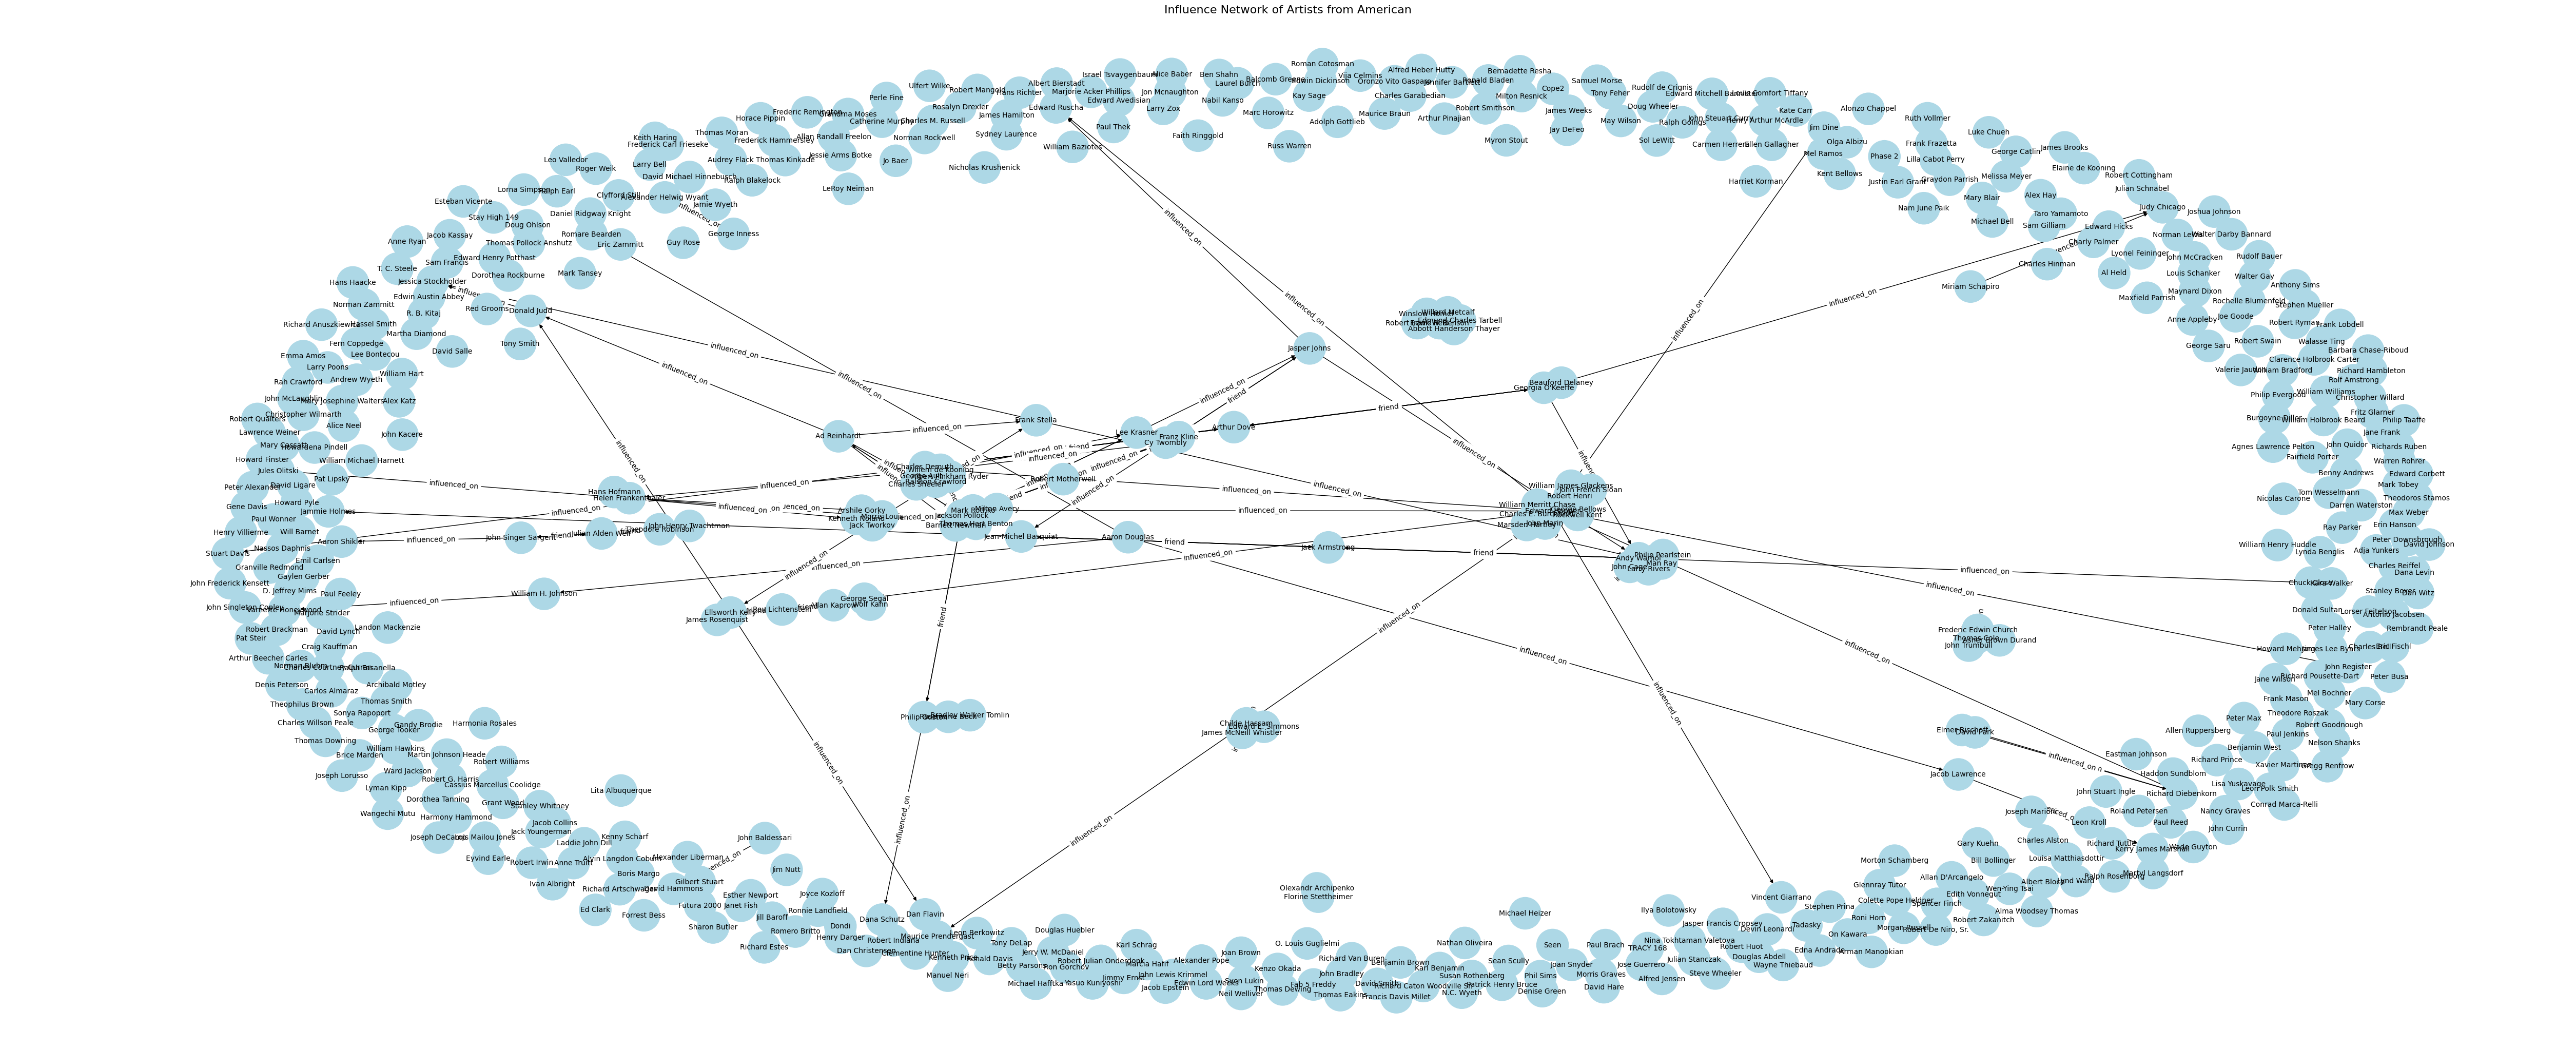

In [793]:
top_nationality, top_count = sorted_nationalities[0]
print(f"Top Nationality: {top_nationality} with {top_count} artists")
subgraph = nx.DiGraph()
for node, data in G.nodes(data=True):
    if data.get("type") == "artist" and data.get("nation") == top_nationality:
        subgraph.add_node(node, **data)
for u, v, data in G.edges(data=True):
        if u in subgraph and v in subgraph:
            subgraph.add_edge(u, v, relationship=data["relationship"])
plt.figure(figsize=(50 , 20))
pos = nx.spring_layout(subgraph)


node_colors = []
node_titles = {}

for node, data in subgraph.nodes(data=True):
    node_colors.append("lightblue")
    node_titles[node] = data["title"]

nx.draw(subgraph, pos, with_labels=False, node_size=2000, node_color=node_colors, font_size=10)
nx.draw_networkx_labels(subgraph, pos, labels=node_titles, font_size=10)


edge_labels = {(u, v): d['relationship'] for u, v, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.title(f"Influence Network of Artists from {top_nationality}", fontsize=16)
plt.show()

Node with the most edges:(Baroque) - Degree: 140


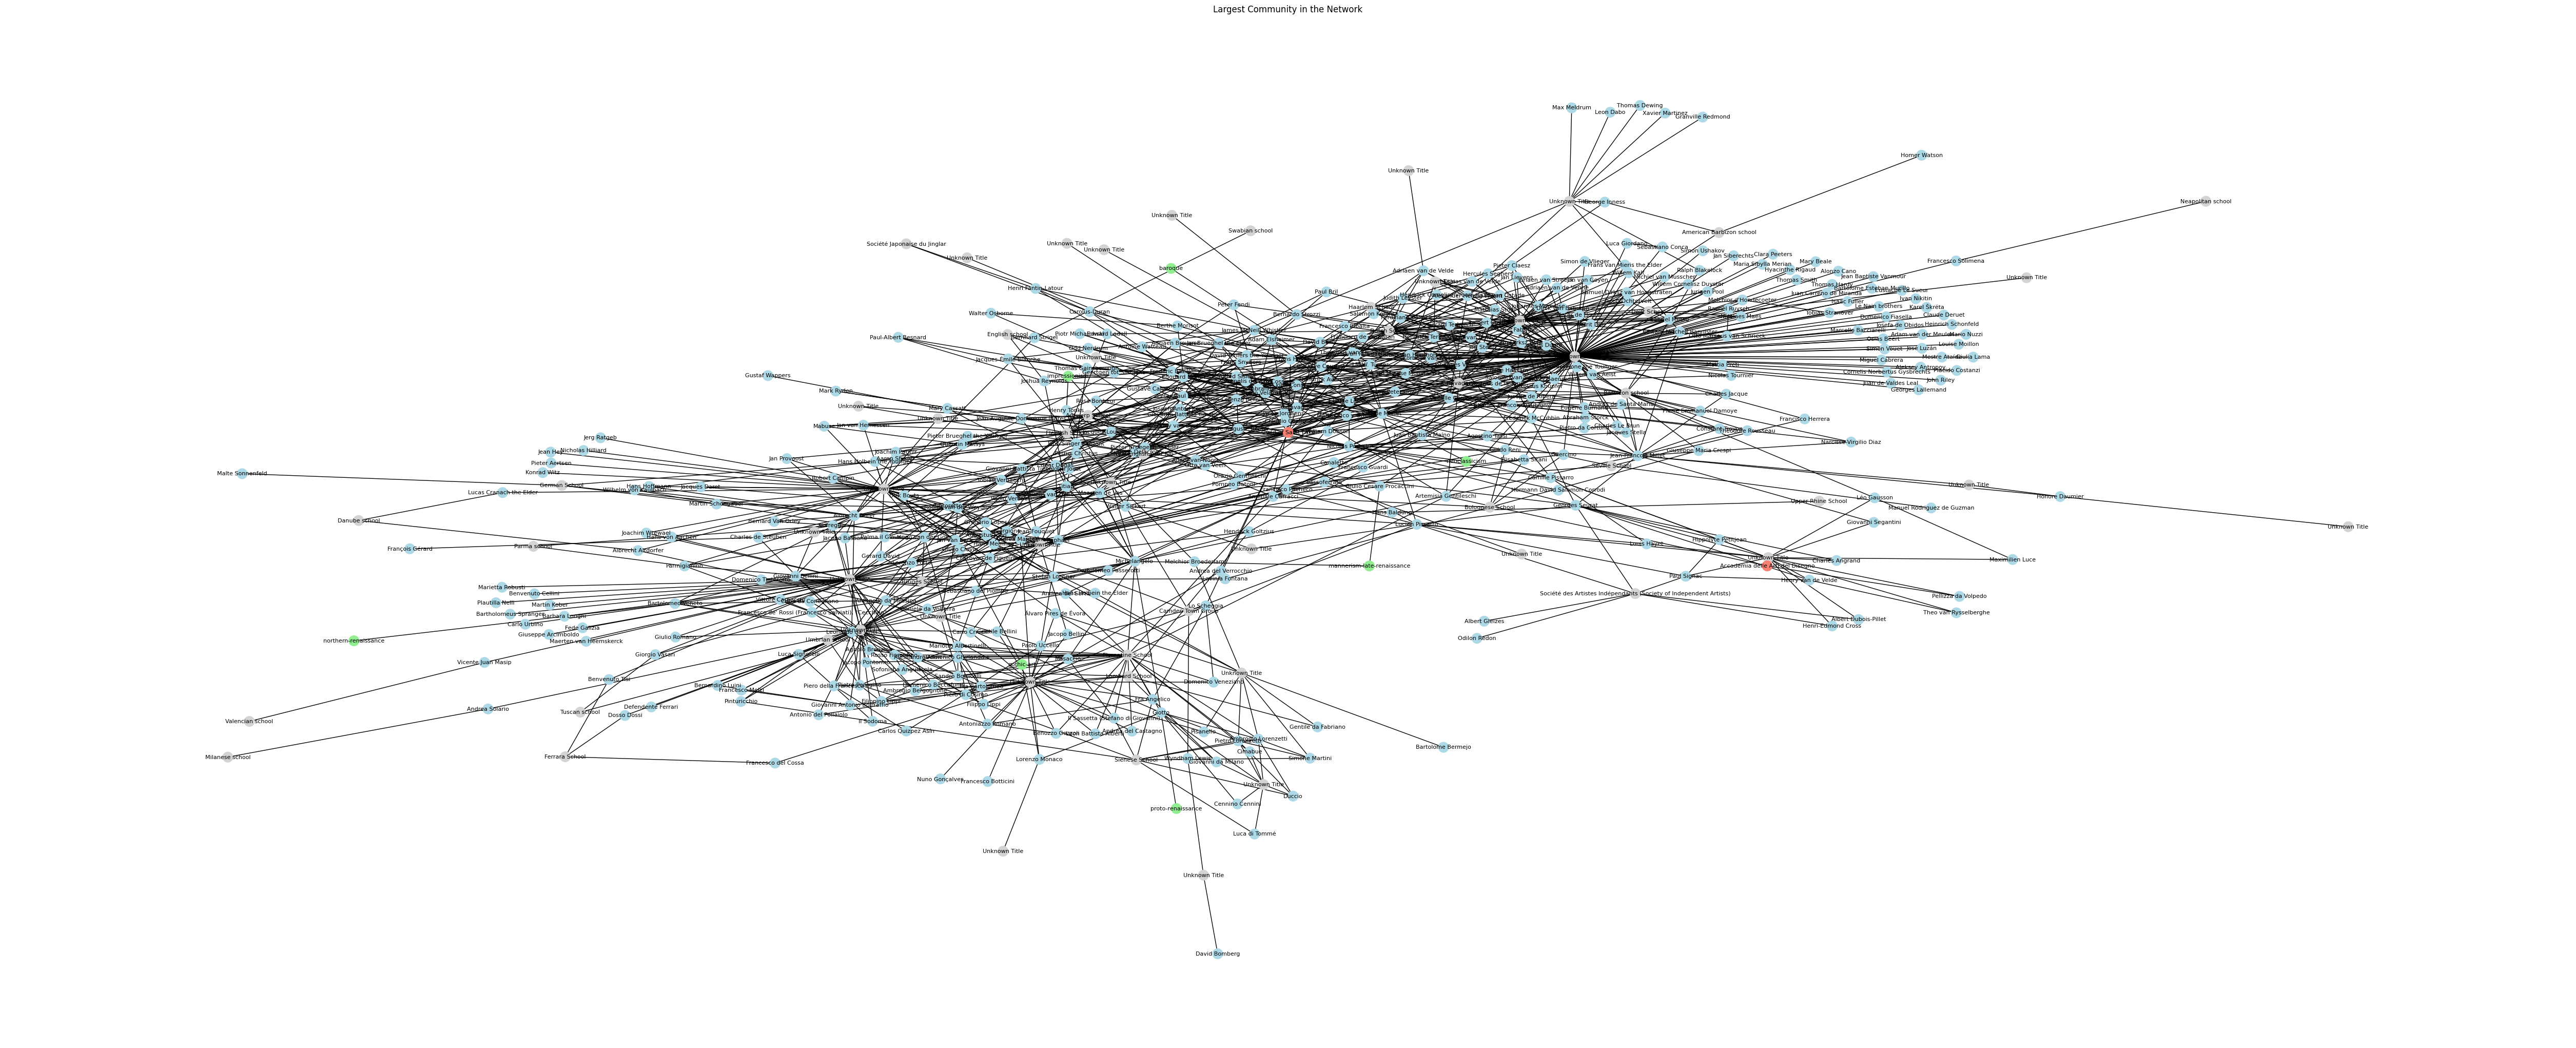

In [798]:
# 5. Which are the biggest communities in the network?
#Create an undirected version of the directed graph
G_undirected = G.to_undirected()

partition = community_louvain.best_partition(G_undirected)

community_counts = {}
for node, comm_id in partition.items():
    if comm_id in community_counts:
        community_counts[comm_id].append(node)
    else:
        community_counts[comm_id] = [node]

community_sizes = {comm_id: len(nodes) for comm_id, nodes in community_counts.items()}
largest_community_id = max(community_sizes, key=community_sizes.get)
largest_community_nodes = community_counts[largest_community_id]


largest_community_subgraph = G_undirected.subgraph(largest_community_nodes)

degree_dict = dict(largest_community_subgraph.degree())
max_node = max(degree_dict, key=degree_dict.get)
max_node_data = largest_community_subgraph.nodes[max_node]


node_title = max_node_data.get("title", "Unknown Title")
print(f"Node with the most edges:({max_node}) - Degree: {degree_dict[max_node]}")


plt.figure(figsize=(50, 20))
pos = nx.spring_layout(largest_community_subgraph)


node_colors = []
node_titles = {}

for node, data in largest_community_subgraph.nodes(data=True):
    node_type = data.get("type", "unknown")
    if node_type == "artist":
        node_colors.append("lightblue")
    elif node_type == "movement":
        node_colors.append("lightgreen")
    elif node_type == "institution":
        node_colors.append("salmon")
    else:
        node_colors.append("lightgray")

    node_titles[node] = data.get("title", "Unknown Title")


nx.draw(largest_community_subgraph, pos, node_color=node_colors, with_labels=False, node_size=200)
nx.draw_networkx_labels(largest_community_subgraph, pos, labels=node_titles, font_size=8)

plt.title("Largest Community in the Network")
plt.show()
